# Multivariate Prediction
*Written by Luke Chang*

The statistical methods we have discussed in this course so far have primarily been concerned with modeling activation in a *single voxel* and testing hypotheses in the form of "where in the brain is activation significantly greater in condition A relative condition B". As you may recall this involved using multilevel modeling with the GLM, where a voxel's time course was modeled using a first level GLM and then the contrast effect was aggregated across participants in the second level model. This procedure is often referred to as mass univariate testing and requires carefully considering how to correct for the many tests across voxels.

$$\text{voxel} = \beta \cdot \text{task model} + \beta \cdot \text{covariates} + \epsilon$$

A completely different approach to the problem is to reverse the regression equation and identify patterns of voxel activations that predict an outcome. This might be **classifying** between different conditions of a task, or **predicting** the intensity of a continuous outcome measure (e.g., emotion, pain, working memory load, etc). 

$$\text{outcome} = \sum_{i}^n \beta_i\cdot \text{voxel}_i + \epsilon$$

Here we are learning a model of $\beta$ values across the brain that when multiplied by new data will predict the intensity of a psychological state or outcome or the probability of being a specific state. 

$$\text{predicted outcome} = \text{model} \cdot \text{brain data}$$

This is the general approach behind *supervised learning* algorithms. The intuition behind this approach is that brain signal might not be functionally localizable to a single region, but instead might be distributed throughout the brain. Patterns of brain activity can thus be used to *decode* psychological states.

The focus of this supervised learning approach is to accurately predict or classify the outcome, whereas the goal in classical statistics is to test hypotheses about *which* regressor explains the most independent variance of the dependent variable. These two approaches are complementary, but require thinking carefully about different issues. 

In mass-univariate testing, we spent a lot of time thinking carefully about independence of errors (e.g., multi-level models) and correcting for multiple hypothesis tests. In multivariate prediction/classification or **multivoxel pattern analysis** as it is often called, we need to carefully think about **feature selection** -  which voxels we will include in our model, and **cross-validation** - how well our model will *generalize* to new data. In MVPA, we typically have more features (i.e., voxels) then data points (i.e., n < p), so this requires performing feature selection or a data reduction step. The algorithms used to learn patterns come from the field of machine-learning are very good at detecting patterns, but have a tendency to *overfit* the training data.

In this tutorial, we will cover the basic steps of multivariate prediction/classification:

1. **Data Extraction** - what data should we use to train model?
2. **Feature Selection** - which features or voxels should we use?
3. **Cross-validation** - how do we train and test the model?
4. **Model Interpretation** - how should we interpret the model?

# Why MVPA?

For most of our tutorials, we have tended to focus on the basics of *how* to perform a specific type of analysis, and have largely ignored questions about *why* we might be interested in specific questions. While univariate GLM analyses allow us to localize which regions might be associated with a specific psychological process, MVPA analyses, and specifically multivariate decoding, allows us to identify distributed representations throughout the brain. These might be localizable to a single region, or may be diffusely encompass many different brain systems.

Before we dive into the details of how to conduct these analyses, let' learn a little bit about the theoretical background motivating this appraoch in two videos from Tor Wager.


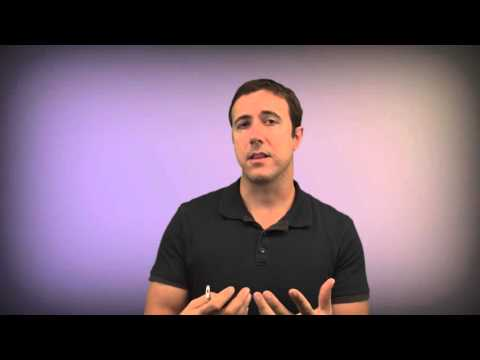

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('87yKz23sPnE')

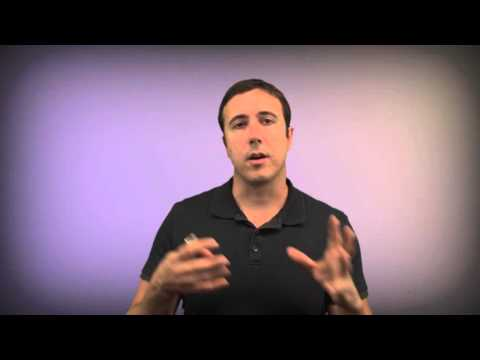

In [2]:
YouTubeVideo('FAyPEr7eu4M')

# Important MVPA Concepts
Now, we are ready to dive into the details. In this tutorial, we will be using the nltools toolsbox to run these models, but also see ([nilearn](https://nilearn.github.io/), [brainiak](https://brainiak.org/tutorials/), and [pyMPVA](http://www.pymvpa.org/)) for excellent alternatives. 

Running MVPA style analyses using multivariate regression is surprisingly easier and faster than univariate methods. All you need to do is specify the algorithm and cross-validation parameters. Currently, we have several different linear algorithms implemented from [scikit-learn](http://scikit-learn.org/stable/) in the nltools package.

To make sure you understand all of the key concepts involved in the practical aspects of conducting MVPA, let's watch two short videos by Martin Lindquist before we dive into the code. 

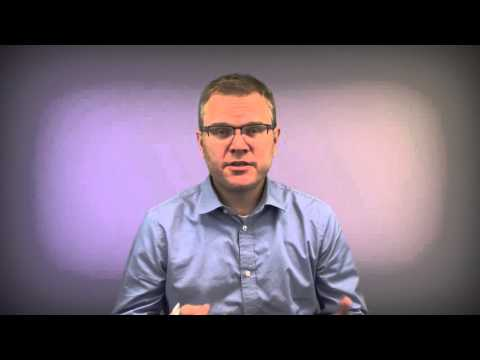

In [1]:
YouTubeVideo('dJIb5bzkQHQ')

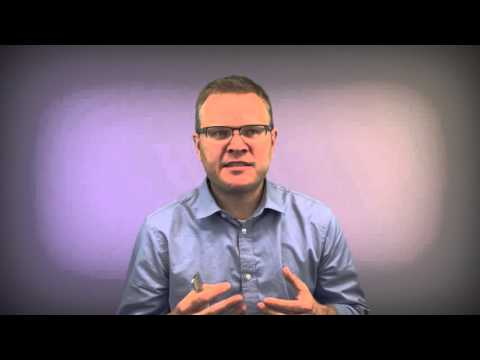

In [2]:
YouTubeVideo('zKMsJyiL5Dc')

## Data Extraction

The first step in MVPA is to decide what data you want to use to predict your outcome variable. Typically, researchers perform a temporal data reduction step, which involves estimating a standard univariate GLM using a single subject first-level model. This model will specify regressors for a single trial, or model a specific condition type over many trials. Just as in the standard univariate approach, these regressors are convolved with an HRF function. These models also usually include nuisance covariates (e.g., motion parameters, spikes, filters, linear trends, etc.). The estimated beta maps from this temporal reduction step are then used as the input data into the prediction model. Note that it is also possible to learn a *spatiotemporal* model that includes the voxels from each TR measured during a a given trial, but this is less common in practice.

First, let's load the modules we need for this analysis.

In [8]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.mask import expand_mask
from bids import BIDSLayout, BIDSValidator

data_dir = '../data/localizer'
layout = BIDSLayout(data_dir, derivatives=True)

/Users/lukechang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


Now let's load some data to train a model.

In this example, let's continue to use data from the Pinel Localizer Task that we have been using throughout all of our tutorials. For our first analysis, let's attempt to classify *Left* from *Right* motor activation. We will load a single beta image for each subject that we already estimated in earlier tutorials. We are sorting the files so that subjects are in the same order, then we are stacking all of the images together using `.append()` such that the data looks like $Subject_{1, left}, ... Subject_{n, left}, Subject_{1, right}, ... Subject_{n, right}$.

In [9]:
left_file_list = glob.glob(os.path.join(data_dir, 'derivatives','fmriprep', '*','func','*_video_left*.nii.gz'))
left_file_list.sort() 
left = Brain_Data(left_file_list)

right_file_list = glob.glob(os.path.join(data_dir, 'derivatives','fmriprep', '*','func','*_video_right*.nii.gz'))
right_file_list.sort()
right = Brain_Data(right_file_list)

data = left.append(right)

Next, we need to create the labels or outcome variable to train the model. We will make a vector of ones and zeros to indicate left images and right images, respectively.

We assign this vector to the `data.Y` attribute of the Brain_Data instance.

In [10]:
Y = pd.DataFrame(np.hstack([np.ones(len(left_file_list)), np.zeros(len(left_file_list))]))

data.Y = Y

okay, we are ready to go. Let's now train our first model. We will use a support vector machine (SVM) to learn a pattern that can discriminate left from right motor responses across all 9 participants.

overall accuracy: 1.00
threshold is ignored for simple axial plots


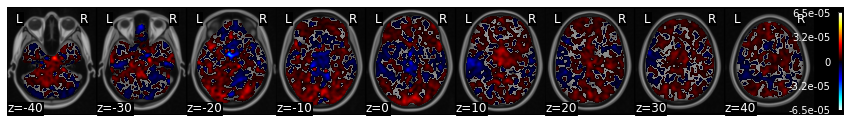

In [11]:
svm_stats = data.predict(algorithm='svm', **{'kernel':"linear"})

the results of this analysis are stored in a dictionary.

- **Y**: training labels
- **yfit_all**: predicted labels
- **dist_from_hyperplane_all**: how far the prediction is from the classifier hyperplane through feature space, > 0 indicates left, while < 0 indicates right.
- **intercept**: scalar value which indicates how much to add to the prediction to get the correct class label.
- **weight_map**: multivariate brain model
- **mcr_all**: overall model accuracy in classifying training data

In [12]:
print(svm_stats.keys())

dict_keys(['Y', 'yfit_all', 'dist_from_hyperplane_all', 'intercept', 'weight_map', 'mcr_all'])


You can see that that the model can perfectly discriminate between left and right using the training data. This is great, but we definitely shouldn't get our hopes up as this model is completely being overfit to the training data. To get an unbiased estimate of the accuracy we will need to test the model on independent data.

We can also examine the model weights more thoroughly by plotting it.  This shows that we see a very nice expected motor cortex representation, but notice that there are many other regions also contributing to the prediction.

In [13]:
svm_stats['weight_map'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Feature Selection

Feature selection describes the process of deciding which features to include when training the model.  Here it is simply, which voxels should we use to train the model?

There are several ways to perform feature selection.  Searchlights are a popular approach.  I personally have a preference for using parcellation schemes.
 - Parcellations are orders of magnitude computationally less expensive than searchlights.
 - Parcellations are easier to correct for multiple comparisons (50 vs 300k)
 - Parcellations can include regions distributed throughout the brain (searchlights are only local)
 - Parcellations can be integrated into a meta-model.
 
Here we download a single 50 parcel map from a forthcoming paper on conducting automated parcellations using neurosynth.

    Yarkoni, T., de la Vega, A., & Chang, L.J. (In Prep).  Fully automated meta-analytic clustering and decoding of human brain activity

Some of the details can be found [here](http://cosanlab.com/static/papers/delaVega_2016_JNeuro.pdf)

threshold is ignored for simple axial plots


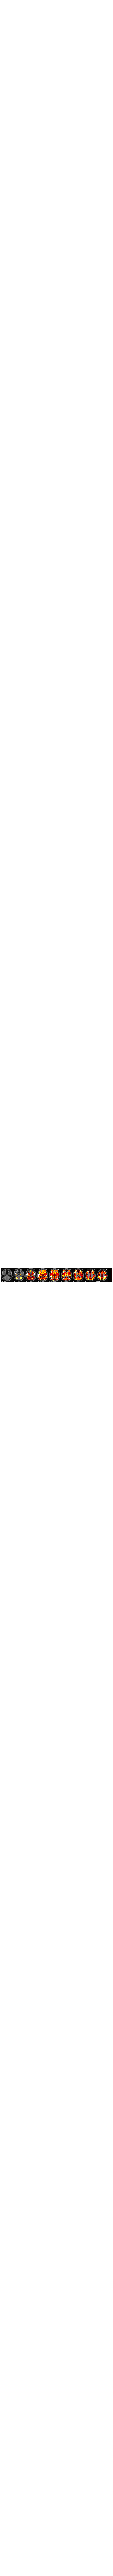

In [17]:
mask = Brain_Data(os.path.join('..', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

mask.plot()

Let's combine two parcels (left-26 and right-47 motor) to make a mask and use this as a feature extract method.

This means that we will only be training voxels to discriminate between the two conditions if they are in the right or left motor cortex.

Plotting unthresholded image
overall accuracy: 1.00
threshold is ignored for simple axial plots


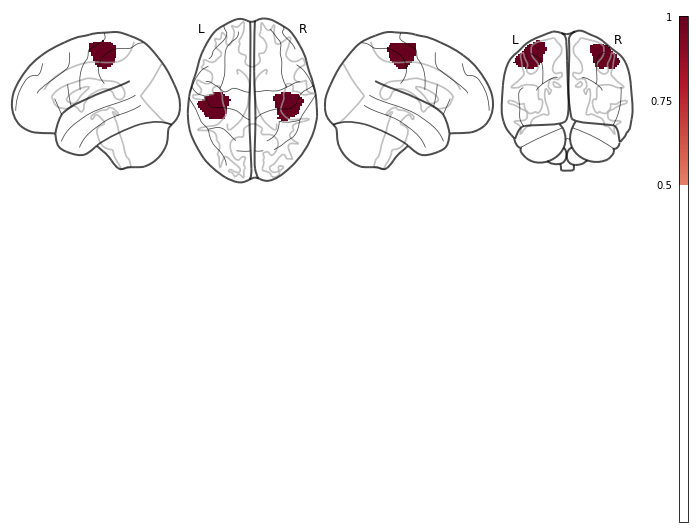

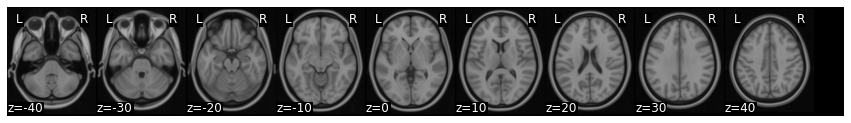

In [19]:
motor = mask_x[[26,47]].sum()
motor.plot(view='glass')

data_masked = data.apply_mask(motor)

svm_stats_masked = data_masked.predict(algorithm='svm', **{'kernel':"linear"})

In [20]:
svm_stats_masked['weight_map'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

We can see that this also correctly learns that left motor cortex is positive while right cortex is negative - left vs right classification.  In addition, the training accuracy is still 100%. 

## Cross-Validation

Clearly, our model is overfitting our training data. The next thing we need to do is to estimate how well our model will generalize to *new* data.  Ideally, we would have left out some data to test after we are done training and tuning our models.  This is called **holdout data** and should only be tested once when you are ready to write up your paper.

However, we don't always have the luxury of having so much extra data and also we might want to tune our model using different algorithms, features, or adjusting hyperparameters of the model.

The best way to do this, is to use **cross-validation**. The idea behind this is to subdivide the data into training and testing partitions - k-folds cross-validation is a common method - divide the data into $k$ separate folds and use all of the data except for one fold to train the model and then test the model using the left out fold. We iterate over this process for each fold. For example, consider k=2 or split-half cross-validation.

![cv.png](../../images/multivariate/cv.png)

We divide the data into two partitions. We estimate the model using half of the data and test it on the other half and then evaluate how well the model performed. As you can see from this simulation, the model will almost always fit the training data better than the test data, because it is overfitting to the noise inherent to the training data, which is presumably independent across folds. More training data will lead to better estimation. This means that a k > 2 will usually result in better model estimates. When k=number of subjects, we call this *leave-one-subject-out* cross-validation.

One key concept to note is that it is very important to ensure that the data is independent across folds or this will lead to a biased and usually overly optimistic generalization. This can happen if you have multiple data from the same participant. You will need to make sure that the data from the same participants are held out together. We can do this by passing a vector of group labels to make sure that data within the same group are held out together. Another approach is to make sure that the data is equally representative across folds. We can use something called stratified sampling to achieve this (see [here](http://cosanlab.com/static/papers/Changetal2015PLoSBiology.pdf) for more details)

Let's add cross-validation to our SVM model.  We will start with $k=5$, and will pass a vector indicating subject labels as our grouping variable.


overall accuracy: 1.00
overall CV accuracy: 0.78
threshold is ignored for simple axial plots


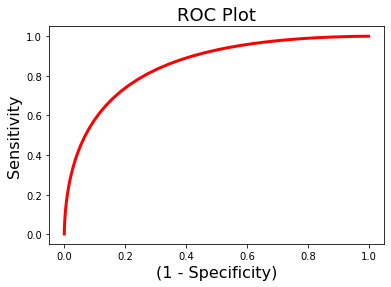

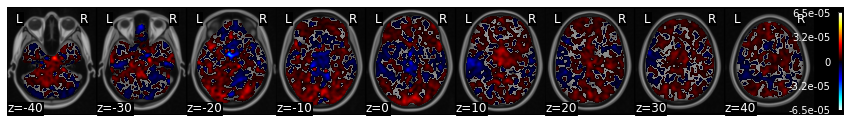

In [21]:
sub_list = [os.path.basename(x).split('_')[0] for x in right_file_list]
subject_id = pd.DataFrame(sub_list + sub_list)

svm_stats = data.predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'kernel':"linear"})

Now we see that our whole-brain model is still performing very well ~78% accuracy.

What about our masked version?

overall accuracy: 1.00
overall CV accuracy: 0.83
threshold is ignored for simple axial plots


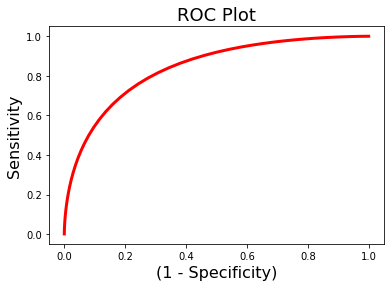

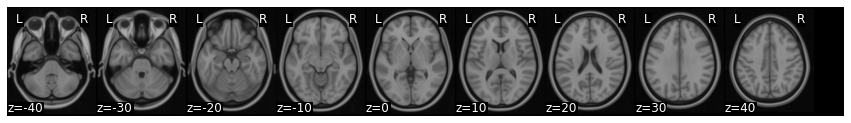

In [22]:
motor = mask_x[[26,47]].sum()
data_masked = data.apply_mask(motor)

svm_stats_masked = data_masked.predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'kernel':"linear"})

Wow, it looks like the model with feature selection actually outperforms the whole-brain model in cross-validation! 83% > 78% accuracy.

Why do you think this is the case?

## Regularization
Another key concept that is used to help with feature selection is called regularization. Regularization is a method to help deal with [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and also avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting). Overfitting occurs when you have an overly complex model such as having more features(Xs) than observations(Y) (n < p). For instance, if you try to fit 10 observations with 10 features, each coefficient can be adjusted for a perfect fit but it wouldn't generalize well. In other cases, you might face the problem of feature selection. If you have numerous variables, it is time consuming to try every single combination of features in your model to see what yields the best result. 
<img src="http://i.stack.imgur.com/0NbOY.png">

Regularization attempts to solve this problem by introducting a loss function that penalizes the model for each additional features added to the model. There are two common types of loss functions *L1* and *L2*. L1 regularization is commonly referred to as *lasso* and leads to sparse solutions, where some regressors are set to zero. L2 regularization, does not lead to a sparse solution, but instead shrinks collinear variables towards zero. Elastic Nets are a type of model that combines L1 and L2 penalizations.

### Lasso regression - L1 Regularization
In short, [Lasso](http://stats.stackexchange.com/questions/17251/what-is-the-lasso-in-regression-analysis) is a feature selection method that reduces the number of features to use in a regression.  
This is useful if you have a lot of variables that are correlated or you have more variables than observations.  

### Ridge Regression - L2 Regularization
The goal of the ridge function is to choose a penalty $\lambda$ for which the coefficients are not rapidly changing and have “sensible” signs. It is especially useful when data suffers from multicollinearity, that is some of your predictor variables are highly correlated. Unlike LASSO, ridge does not produce a sparse solution, but rather shrinks variables that are highly collinear towards zero.

### How do we determine the penalty value? 
Both Lasso and Ridge regressions have a penalty hyperparameter $\lambda$. Essentially, we want to select the regularization parameter by identifying the one from a set of possible values (e.g. grid search) that results in the best fit of the model to the data.  However, it is important to note that it is easy to introduce bias into this process by trying a bunch of alphas and selecting the one that works best.  This can lead to optimistic evaluations of how well your model works.

Cross-validation is an ideal method to deal with this.  We can use cross-validation to select the alpha while adding minimal bias to the overall model prediction.

Here we will demonstrate using both to select an optimal value of the regularization parameter alpha of the Lasso estimator from an example provided by [scikit-learn](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html). For cross-validation, we will use a nested cross-validation as implemented by the LassoCV algorithm.  Note that these examples with nested cross-validation take much longer to run.

overall accuracy: 1.00
overall CV accuracy: 0.72
threshold is ignored for simple axial plots


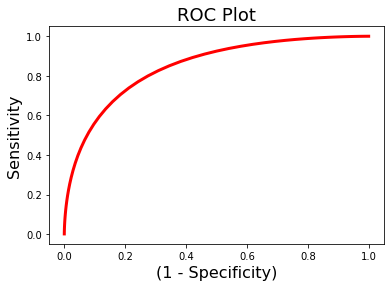

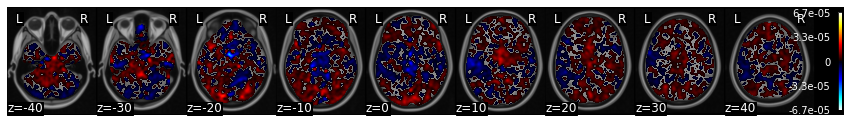

In [23]:
ridge_stats = data.predict(algorithm='ridgeClassifier', 
                        cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id},
                           **{'alpha':.01})

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.50
overall CV Correlation: 0.56
threshold is ignored for simple axial plots


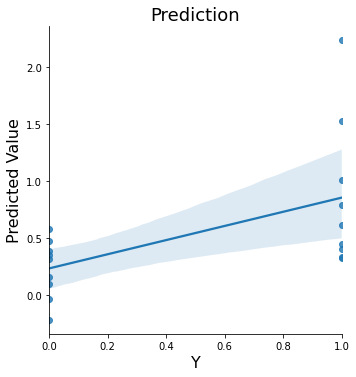

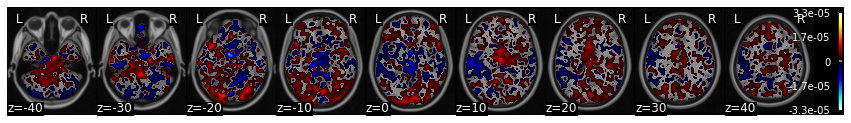

In [24]:
ridge_stats = data.predict(algorithm='ridgeCV',
    cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id})

In [ ]:
lasso_cv_stats = data.predict(algorithm='lassoCV',
    cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id})

## Classification and Class Imbalance

One important thing to note is that when you use classification, it is important to account for class imbalances. i.e., that there might be unequal amounts of data in each group.  The reason why this is a problem is that chance classification is no longer at 50% when there is a class imbalance.  Suppose you were trying to classify A from B, but 80% of the data were instances of B. A classifier that always says B, would be correct 80% of the time. 

There are several different ways to deal with class imbalance.

1) **Make the Class Sizes Equal** You can randomly sample data that is overrepresented to create your own balanced dataset. Advantages are that the data classes will be balanced. The disadvantage of this approach is that you are not using all of your data.

2) **Average Data** You can average all of the data within a class so that each participant only has one data point per class. Advantages are the data are balanced. Disadvantages are that you have dramatically reduced the amount of data going into training the model.

3) **Balance Class Weights** If you are using SVM, you can set `class_weight=balanced`. The general idea is to increase the penalty for misclassifying minority classes to prevent them from being “overwhelmed” by the majority class. See [here](https://chrisalbon.com/machine_learning/support_vector_machines/imbalanced_classes_in_svm/) for a brief overview.

When testing your model you can also make adjustments to calculate a balanced accuracy. Scikit-learn has the [`balanced_accuracy_score` method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html), which implements the technique outlined in [this](https://ieeexplore.ieee.org/document/5597285) paper. It essentially defines accuracy as the average recall obtained on each class.

Let's test an example using the `'class_weight'='balanced'` approach.

overall accuracy: 1.00
overall CV accuracy: 0.78
threshold is ignored for simple axial plots


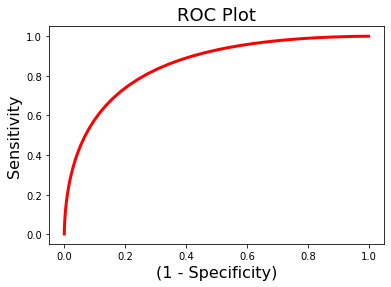

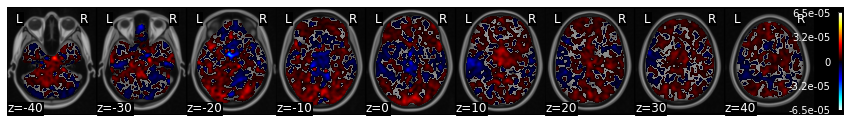

In [26]:
svm_stats = data.predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id}, **{'class_weight':'balanced', 'kernel':"linear"})


# MVPA Patterns as Biomarkers
Now that we know how to train multivariate patterns, what can we do with them? There has been a lot of interest in their potential to serve as neural biomarkers of psychological states.  If you would like to learn about how these can be used to better understand how we process and experience pain, watch these two videos by Tor Wager, where he summarizes some of the groundbreaking work he has been doing in this space.

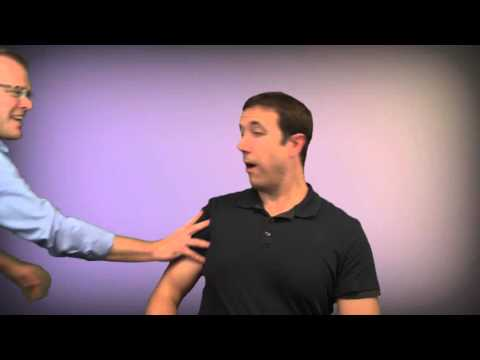

In [6]:
YouTubeVideo('LV51_3jHg_c')

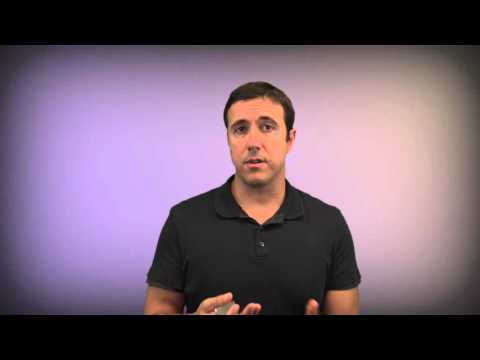

In [3]:
YouTubeVideo('3iXh0FzuAjY')

# Additional Resources
If you are feeling like you would like to learn more about some of the details and possibilities of this approach, we encourage you to read some of the many review papers from [Haynes & Rees, 2006](https://www.nature.com/articles/nrn1931), [Naselaris et al., 2011](https://www.sciencedirect.com/science/article/pii/S1053811910010657), [Haxby et al., 2014](https://www.annualreviews.org/doi/full/10.1146/annurev-neuro-062012-170325), [Woo et al, 2017](http://cosanlab.com/static/papers/Woo_2017_NN.pdf).

There are also many great books covering the machine-learning including the freely available [the elements of statistical learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) and [pattern recognition and machine-learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf).

Finally, Here is a helpful [blog post](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/) on different algorithms and reasonable default parameters.


# Exercises

## Exercise 1. Vertical vs Horizontal Checkerboard Classification.

For this exercise, find a multivariate pattern that can discriminate between horizontal and vertical checkerboards in new participants with SVM and leave-one-subject out cross-validation.

## Exercise 2. Generalizing Patterns.
Now, let's see how well this pattern generalizes to other conditions. See which other conditions this pattern appears to generalize too by applying the pattern to all of the participants. Does it only get *confused* for conditions involving visual information?